# Bước 1: Chuẩn bị Dữ liệu và Phân tích Khám phá (EDA)

**Mục tiêu:** Tải dữ liệu giá đóng cửa của 5 cổ phiếu blue-chip Việt Nam (HPG, VHM, MWG, VCB, FPT), tính log returns, xử lý dữ liệu, và thực hiện phân tích khám phá.

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import skew, kurtosis
import os

In [3]:
# Import các hàm xử lý dữ liệu từ src/data_prep.py
import sys
sys.path.append('../src')
from data_prep import (
    load_multiple_csv_to_df, compute_log_returns, check_negative_or_zero,
    check_outliers, report_missing_values, save_to_csv
 )

## Tải dữ liệu giá đóng cửa của 5 cổ phiếu (15 năm gần nhất)

Lưu ý: Mã cổ phiếu Việt Nam trên Yahoo Finance thường có hậu tố '.VN' (ví dụ: HPG.VN).

In [6]:
processed_folder = '../data/processed'

print("Loading and merging raw data...")
data = load_multiple_csv_to_df('../data/raw', dropna_type=any, min_non_na=None)
print(f"Data shape after merge: {data.shape}")
# Remove rows with closing price <= 0
data = check_negative_or_zero(data)
print(f"Data shape after removing <=0: {data.shape}")
# Check missing values
report_missing_values(data)
# Save cleaned price data
price_path = os.path.join(processed_folder, 'price_cleaned.csv')
save_to_csv(data, price_path)
print(f"Saved cleaned price data to {price_path}")
# Compute log returns
log_returns = compute_log_returns(data)
# Round to 6 decimals for readability
log_returns = log_returns.round(6)
logret_path = os.path.join(processed_folder, 'log_returns.csv')
save_to_csv(log_returns, logret_path)
print(f"Saved log returns to {logret_path}")
print("Data preparation pipeline completed.")

Loading and merging raw data...
Data shape after merge: (2777, 5)
Data shape after removing <=0: (2777, 5)
Missing values per ticker:
FPT_DATA    0
HPG_DATA    0
MWG_DATA    0
VCB_DATA    0
VIC_DATA    0
dtype: int64
Total number of rows with missing values: 0
Saved cleaned price data to ../data/processed\price_cleaned.csv
Saved log returns to ../data/processed\log_returns.csv
Data preparation pipeline completed.


c:\Users\HLC\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\notebooks\../src\data_prep.py:21: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


## Phân tích khám phá: Vẽ biểu đồ log returns và tính thống kê mô tả

--- FPT_DATA ---


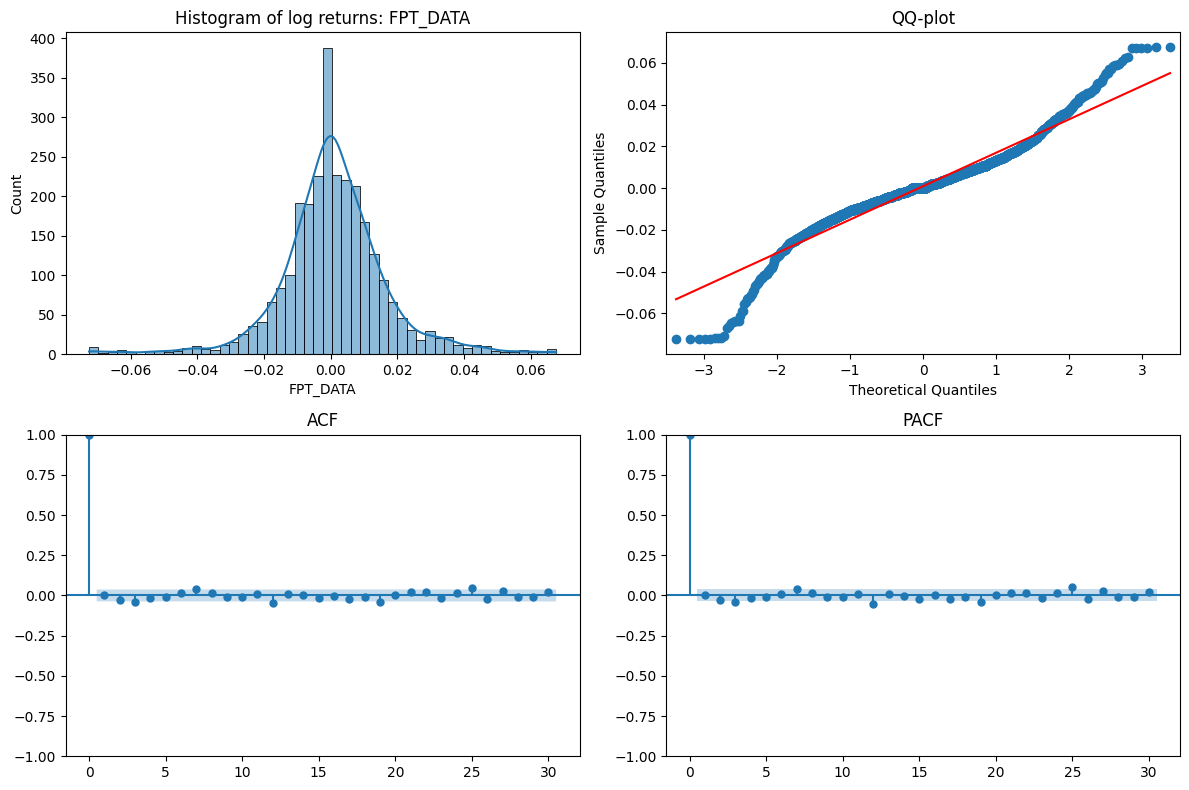

Normality test p-value: 0.0000
ARCH test p-value: 0.0000

--- HPG_DATA ---


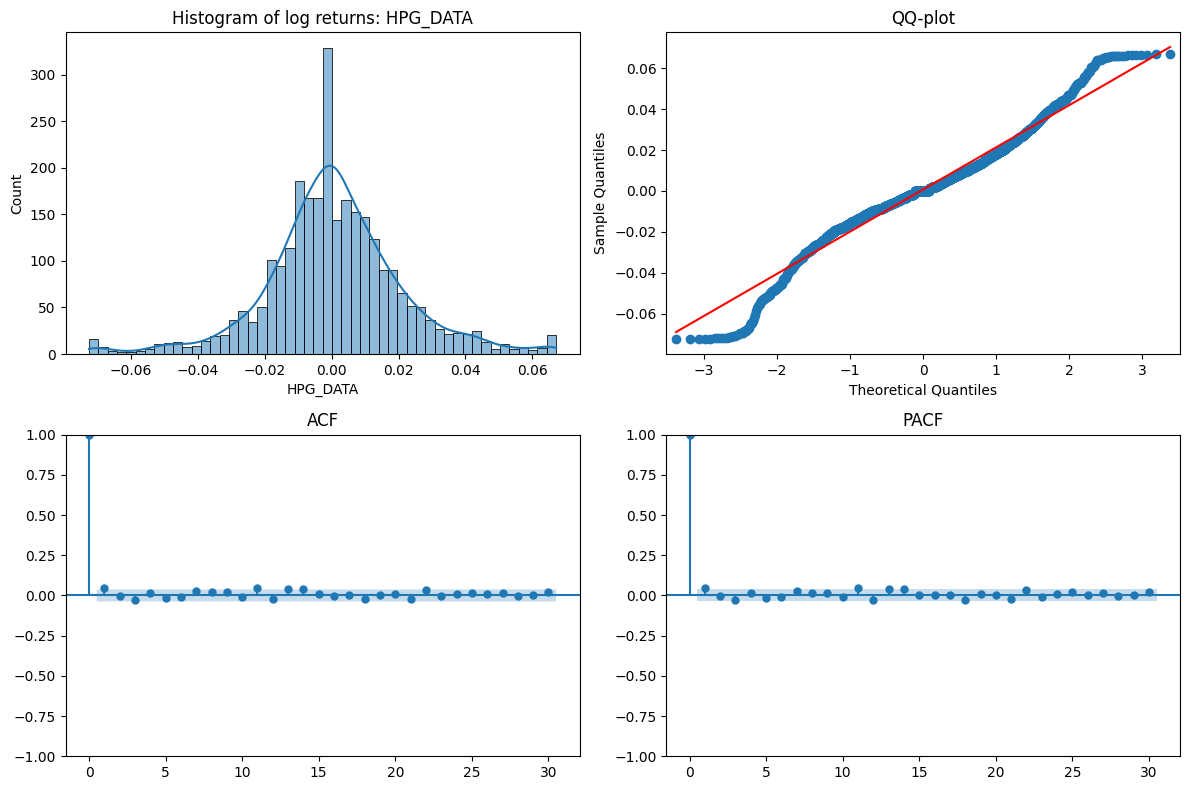

Normality test p-value: 0.0000
ARCH test p-value: 0.0000

--- MWG_DATA ---


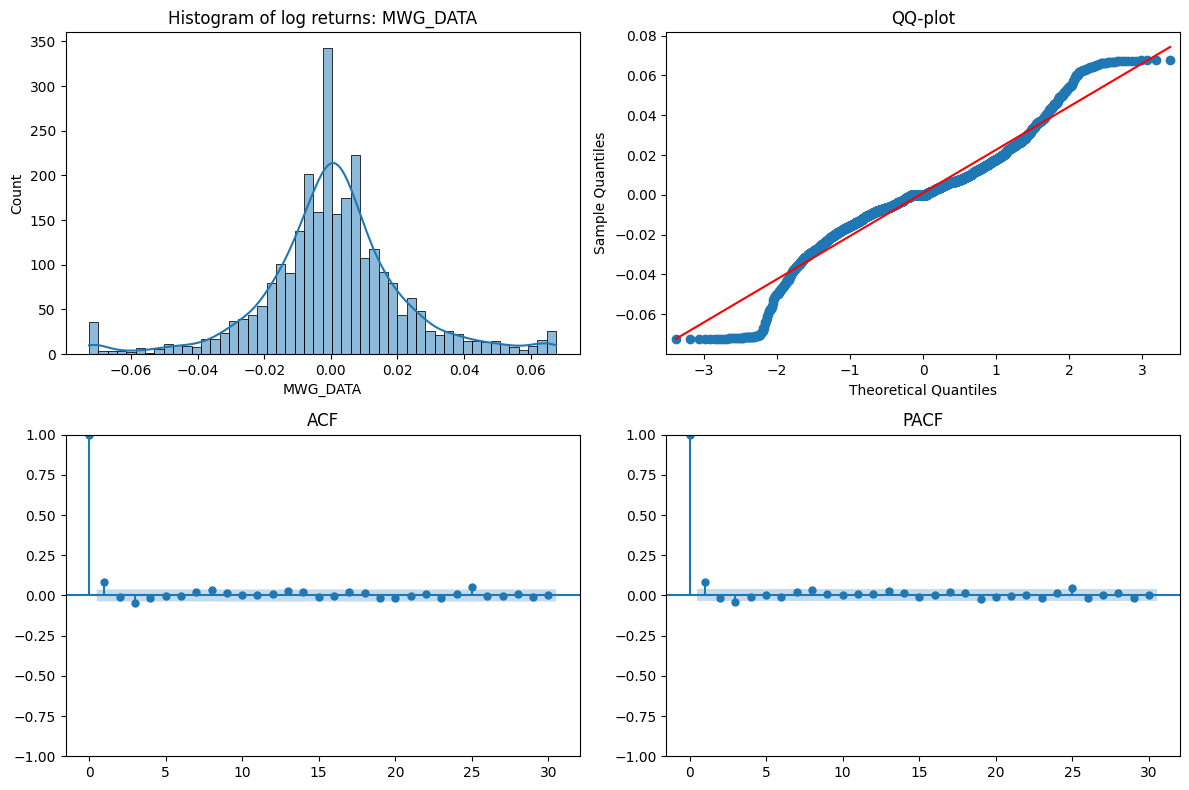

Normality test p-value: 0.0000
ARCH test p-value: 0.0000

--- VCB_DATA ---


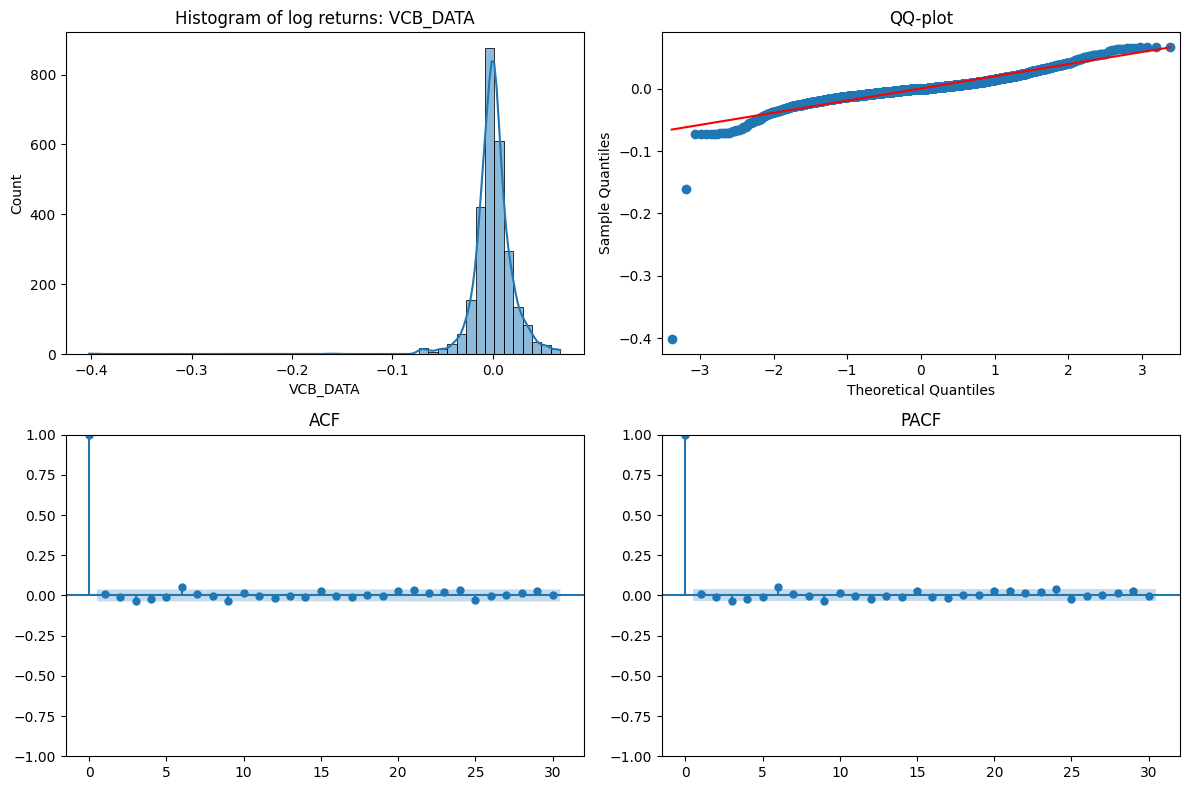

Normality test p-value: 0.0000
ARCH test p-value: 1.0000

--- VIC_DATA ---


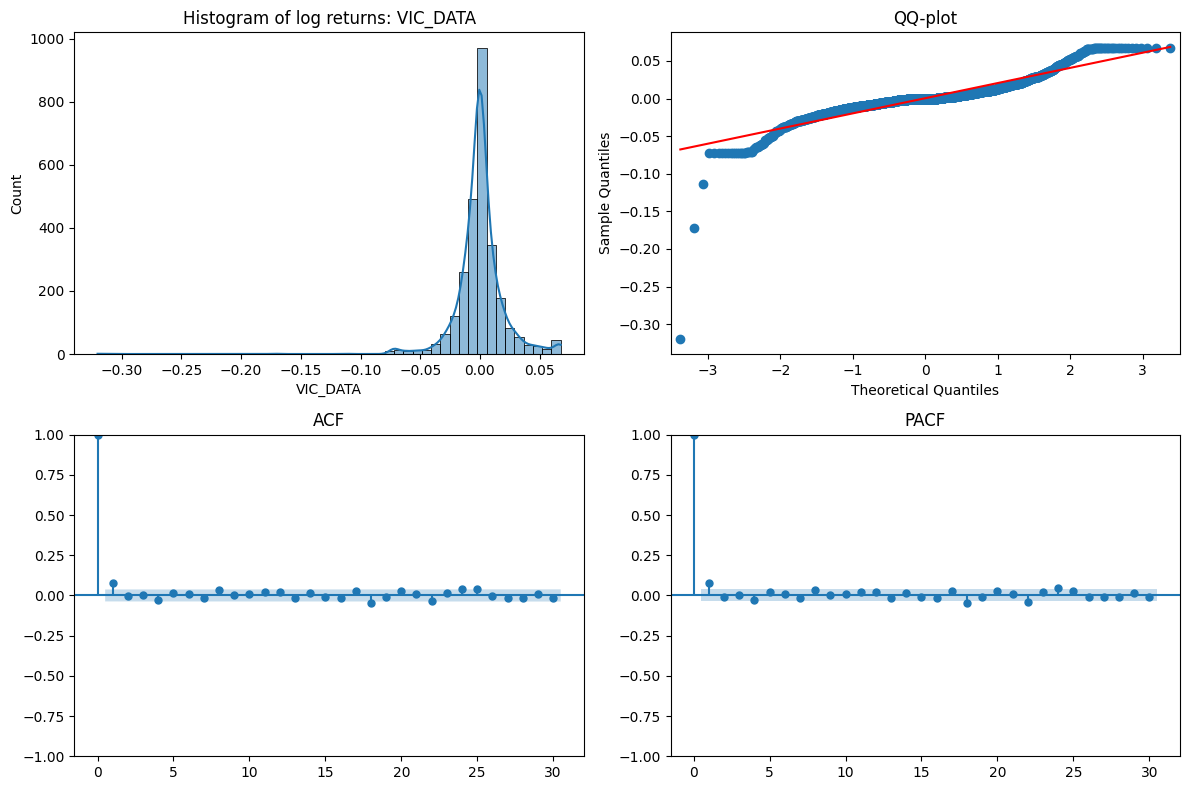

Normality test p-value: 0.0000
ARCH test p-value: 0.0547



In [9]:
# Phân tích khám phá log returns cho từng cổ phiếu
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
tickers = log_returns.columns.tolist()

for ticker in tickers:
    print(f'--- {ticker} ---')
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    # Histogram
    sns.histplot(log_returns[ticker].dropna(), bins=50, kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Histogram of log returns: {ticker}')
    # QQ-plot
    sm.qqplot(log_returns[ticker].dropna(), line='s', ax=axes[0,1])
    axes[0,1].set_title('QQ-plot')
    # ACF
    plot_acf(log_returns[ticker].dropna(), ax=axes[1,0], lags=30)
    axes[1,0].set_title('ACF')
    # PACF
    plot_pacf(log_returns[ticker].dropna(), ax=axes[1,1], lags=30, method='ywm')
    axes[1,1].set_title('PACF')
    plt.tight_layout()
    plt.show()

    # Kiểm tra normality
    k2, p = stats.normaltest(log_returns[ticker].dropna())
    print(f'Normality test p-value: {p:.4f}')
    # Kiểm tra ARCH effect
    from statsmodels.stats.diagnostic import het_arch
    arch_test = het_arch(log_returns[ticker].dropna())
    print(f'ARCH test p-value: {arch_test[1]:.4f}')

    print()

In [ ]:
fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 2*len(tickers)), sharex=True)
for i, ticker in enumerate(tickers):
    axes[i].plot(log_returns.index, log_returns[ticker], label=ticker)
    axes[i].set_ylabel('Log Return')
    axes[i].legend(loc='upper right')
plt.suptitle('Log Returns của các cổ phiếu')
plt.tight_layout()
plt.show()

In [ ]:
# Tính các thống kê mô tả
desc_stats = log_returns.agg(['mean', 'std', skew, kurtosis])
desc_stats.loc['skew'] = log_returns.apply(skew)
desc_stats.loc['kurtosis'] = log_returns.apply(kurtosis)
desc_stats.T